
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>
    Amirabbas Afzali

____

# Personal Data

In [1]:
# Set your student number
student_number = '401101332'
Name = 'Amirparsa'
Last_Name = 'Bahrami'

# Rules
- Make sure that all of your cells can be run perfectly.
- Try to minimize your use of ChatGPT (or any other AI assistant) as much as possible.
- You must create a report for this task in PDF format and explain the main results.

---

## **Introduction**

Large Language Models (LLMs) are a class of deep learning models designed for processing and generating natural language. These models are trained using large amounts of textual data and utilize architectures based on transformers. Some of the applications of these models include text generation, machine translation, text summarization, question answering, and text classification.

### *Encoder-Decoder LLMs*

One of the common architectures in large language models is the Encoder-Decoder architecture. In this architecture, the encoder processes an input sequence and maps it to a latent space. Then, the decoder uses this latent space to generate an output sequence. Models like T5 [1] (Text-to-Text Transfer Transformer) use this architecture to perform various tasks. In T5, all tasks are expressed in a "text-to-text" format, meaning both input and output are text. This model has capabilities such as translation, summarization, and text classification. One of the advantages of the Encoder-Decoder architecture is that it allows the encoder to utilize information from both before and after a word to gain a more comprehensive understanding of the text.

### *Decoder-only LLMs*

Decoder-only models, such as GPT-2, GPT-3, and LLaMA [2], unlike the Encoder-Decoder architecture, only use the decoder part. These models use an autoregressive mode, meaning they predict the next token based on previous tokens. These models are highly efficient for text generation and have found widespread applications today.

Advantages of Decoder-only Models

- Efficiency: Decoder-only models are more efficient than Encoder-Decoder models due to the absence of an independent encoder. This makes them require fewer computational and memory resources.
- Simplicity: Due to their autoregressive nature, these models can easily generate sequences in order.
- Scalability: Due to their simpler architecture, these models can be scaled to much larger sizes.


However, one of the drawbacks of these models is that they can only utilize information from tokens before the current token and cannot use tokens that come after for prediction. This limitation is significant in tasks like classification or translation, where a full understanding of the sequence is needed.



## **Objective of the Exercise**


In this exercise, the goal is to convert a generative Decoder-only language model into an encoder and evaluate its performance on a binary sentiment classification task. The main aim is to modify the Decoder-only model so that it can function as an encoder and better handle tasks requiring bidirectional understanding.

## **In this exercise, you should:**


### In this exercise, you should:

1. **Import a Decoder-only model** and load the weights of a pre-trained version of the model.
2. **Generate several outputs from the model**, and include at most 10 sample outputs in your report for different inputs.  
   You should also briefly explain the effects of key configurations in text generation, including:  
   - `Temperature`
   - `top_k`
   - `top_p`
   - `repetition_penalty`
   - `num_beams`
   - `no_repeat_ngram_size`
3. **Load the SST-2 dataset**, which is part of the GLUE benchmark for sentiment classification.  
   - Note that the model’s output depends on the number of input tokens.
   - Apply necessary padding to the dataset after loading it to allow for parallel execution of the model.
4. **Remove the model’s final layer**, which outputs to the size of the model’s dictionary.  
   - Use the embedding vector of the first token (CLS token) for classification.
5. As observed in the previous step, sometimes the embedding vector of the first token does not provide a good representation of the entire input text.  
   - **Add a linear layer** with the same input and output dimensions on top of the encoder's output, and use the output of this linear layer (corresponding to the CLS token) for classification.  
   - This step aggregates information of different tokens to get a comprehensive understanding of the input text.
6. **Instead of the linear layer** in the previous section, use a **bidirectional attention layer** with a custom number of heads (preferably 12).
7. **Repeat step 6** using **left-to-right unidirectional attention** and **right-to-left unidirectional attention**.
8. **Load a pre-trained decoder** (preferably BERT-base) and report its **zero-shot performance** (i.e., without needing to train the model) on the test data.

## **Evaluation:**

In this exercise, for each of sections 4, 5, 6, 7, and 8, you need to plot the confusion matrix corresponding to the model's performance on the test data. Additionally, you should plot two separate graphs showing the training loss and the accuracy of the trained models, and compare them with each other, providing an appropriate analysis of your results. Also, note that high accuracy is not expected for sections 4 and 5, but the correctness of your code will be checked. However, for sections 6 and 7, higher accuracy (around 90%) is expected.













## **Let's go:**


Load `gpt2` model:

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model
import torch
from torch import nn
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Load `sst-2` dataset:

In [3]:
from datasets import load_dataset

# Load the SST-2 dataset from Hugging Face
dataset = load_dataset("glue", "sst2")

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

go ahead:

###2.Generate Sample Outputs with Different Configurations

In [4]:
sample_prompts = [
    "Once upon a time,",
    "In a shocking discovery,",
    "The future of artificial intelligence",
    "Climate change is",
    "The secret to happiness"
]

In [5]:
def generate_text(prompt, temperature=1.0, top_k=50, top_p=0.95, repetition_penalty=1.0, num_beams=1, no_repeat_ngram_size=0):
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        inputs,
        max_length=50,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        do_sample=True if num_beams == 1 else False
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
print("=== Sample Outputs with Default Settings ===\n")
for prompt in sample_prompts[:2]:  # Limiting to 2 prompts for brevity
    generated = generate_text(prompt)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with Temperature=0.7 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, temperature=0.7)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with top_k=40 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, top_k=40)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with top_p=0.9 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, top_p=0.9)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with repetition_penalty=1.2 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, repetition_penalty=1.2)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with num_beams=5 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, num_beams=5)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")

print("=== Sample Outputs with no_repeat_ngram_size=2 ===\n")
for prompt in sample_prompts[:2]:
    generated = generate_text(prompt, no_repeat_ngram_size=2)
    print(f"Prompt: {prompt}\nGenerated: {generated}\n")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== Sample Outputs with Default Settings ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, and because of the immense number of visitors to this website who were not even aware it was here for this purpose I thought a lot about the events surrounding it.

What I found interesting, although I did not want to



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, the family of his wife and children is accused of murdering their son — and more.

A man has been arrested in London following an apparent suicide attempt, the Metropolitan Police have revealed.

The 23-year-

=== Sample Outputs with Temperature=0.7 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, the king would have ordered the soldiers to go to his house. However, this time, the King had no choice. The soldiers would return to the palace, and the king would not be allowed to leave without a bribe.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, police are investigating a murder committed at the home of the late Pauline Gower, who was the wife of a state senator.

The man, identified only as "Bryan," was found dead inside his home in

=== Sample Outputs with top_k=40 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, a war was waged between the nations of the earth. The nations of the earth began to be torn apart by the powers of the Gods, who brought them into conflict over whom to trust as guardians of a glorious civilization. This



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, a person who claims to be a child psychologist has shared her story of getting involved in the practice.

And she did not want to make the whole thing up!

She shared her story about being on an episode

=== Sample Outputs with top_p=0.9 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, you'll want to consider investing in a personal investment vehicle to begin with.

If you're interested in making sure you keep an eye on your investments regularly and stay up to date on a number of recent investment news and



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, a former member of the Russian security services has reportedly been captured and tortured at the Russian border by a group of militants.

The journalist, who worked for the International Rescue Committee for Ukraine from 2009 until his arrest last November

=== Sample Outputs with repetition_penalty=1.2 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, I was forced into the service of someone else.
It is also not clear if anyone saw me for my work-related and financial activities at that point during this process."

   Follow Politics



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, the CIA is conducting an internal investigation into how Washington's drone program worked.
 After four months of intense scrutiny and pressure from congressional Republicans , Congress passed $14 million in funding for new unmanned aerial vehicles to protect American military

=== Sample Outputs with num_beams=5 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, there was a great deal of confusion about what was going on.

"I think it was just a matter of time," he said. "I think it was just a matter of time. I think it was just



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In a shocking discovery,
Generated: In a shocking discovery, police say a man was shot in the back of the head.

Police say a man was shot in the back of the head.

Police say a man was shot in the back of the head.



=== Sample Outputs with no_repeat_ngram_size=2 ===



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Once upon a time,
Generated: Once upon a time, the word "hindu" and "religious" were used together, then "political," "scientific," etc. The difference is that the term 'hindus' is understood by those who do not want the religious aspect

Prompt: In a shocking discovery,
Generated: In a shocking discovery, the former head of France's Interior Ministry and one of the key aides involved in the country's current scandal-ridden politics has been given the chance to resign, with the French government saying his name was removed from the latest batch



###Explanation of Configurations
Temperature: Controls the randomness of predictions. Lower values make the model more deterministic, while higher values increase diversity.

top_k: Limits the sampling pool to the top k tokens with the highest probability.

top_p: Implements nucleus sampling by considering the smallest set of tokens whose cumulative probability exceeds p.

repetition_penalty: Penalizes repeated tokens to reduce redundancy.

num_beams: Number of beams for beam search. Higher values lead to more exhaustive search.

no_repeat_ngram_size: Prevents the model from repeating n-grams of the specified size.

#Step 3: Load and Prepare the SST-2 Dataset

Define the pad_token
After loading the GPT-2 tokenizer and model, set the pad_token to the eos_token. This ensures that when padding is required, the tokenizer uses the eos_token as the padding token.



In [6]:
# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# Ensure the model is aware of the new pad_token
model.config.pad_token_id = tokenizer.pad_token_id


In [7]:
# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Display a sample
print(dataset['train'][0])


{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


###Tokenization and Padding

In [8]:
# Define maximum sequence length
max_length = 128

def tokenize_function(examples):
    return tokenizer(
        examples['sentence'],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["sentence", "idx"])

# Rename label column to 'labels' to be compatible with Hugging Face models
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Finally, create DataLoaders for training, validation, and testing. These DataLoaders will handle batching and shuffling (for training data).

In [9]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=batch_size)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=batch_size)


#Step 4: Modify the Model by Removing the Final Layer

We'll transform GPT-2 into an encoder by removing its language modeling head and using the hidden states for classification.



In [10]:
# Remove the language modeling head
encoder = GPT2Model.from_pretrained("gpt2").to(device)

# Freeze the encoder parameters (optional, can be unfrozen for fine-tuning)
for param in encoder.parameters():
    param.requires_grad = False

# Define a classifier using the embedding of the first token (CLS token)
class GPT2EncoderClassifier(nn.Module):
    def __init__(self, encoder, hidden_size=768, num_labels=2):
        super(GPT2EncoderClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # First token's embedding
        logits = self.classifier(cls_embedding)
        return logits

model_classifier = GPT2EncoderClassifier(encoder).to(device)


#Training Setup

We'll set up the training loop, loss function, and optimizer.

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_classifier.classifier.parameters(), lr=1e-3)


#Training Function

In [12]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


#Evaluation Function

In [13]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return preds, true_labels


#Training the Model
Given that high accuracy isn't expected for this step, we'll train for a few epochs.

In [ ]:
epochs = 3
train_losses = []
validation_accuracies = []

for epoch in range(epochs):
    train_loss = train(model_classifier, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

    preds, labels = evaluate(model_classifier, validation_dataloader, device)
    acc = accuracy_score(labels, preds)
    validation_accuracies.append(acc)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}\n")


Epoch 1/3
Training Loss: 0.6874
Validation Accuracy: 0.5206

Epoch 2/3
Training Loss: 0.6799
Validation Accuracy: 0.5241

Epoch 3/3
Training Loss: 0.6810
Validation Accuracy: 0.5447



#Confusion Matrix

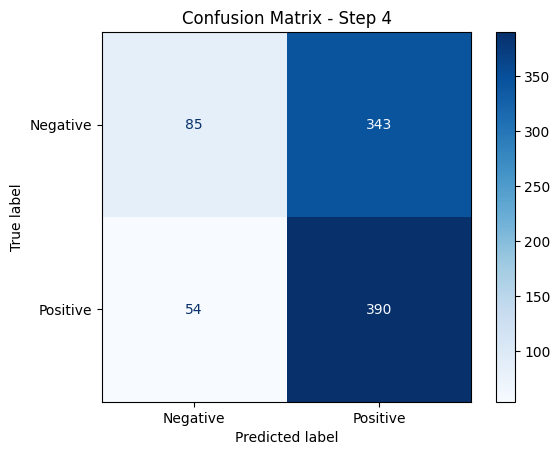

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate on validation set
preds, labels = evaluate(model_classifier, validation_dataloader, device)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 4")
plt.show()


#Training Loss and Accuracy Plot

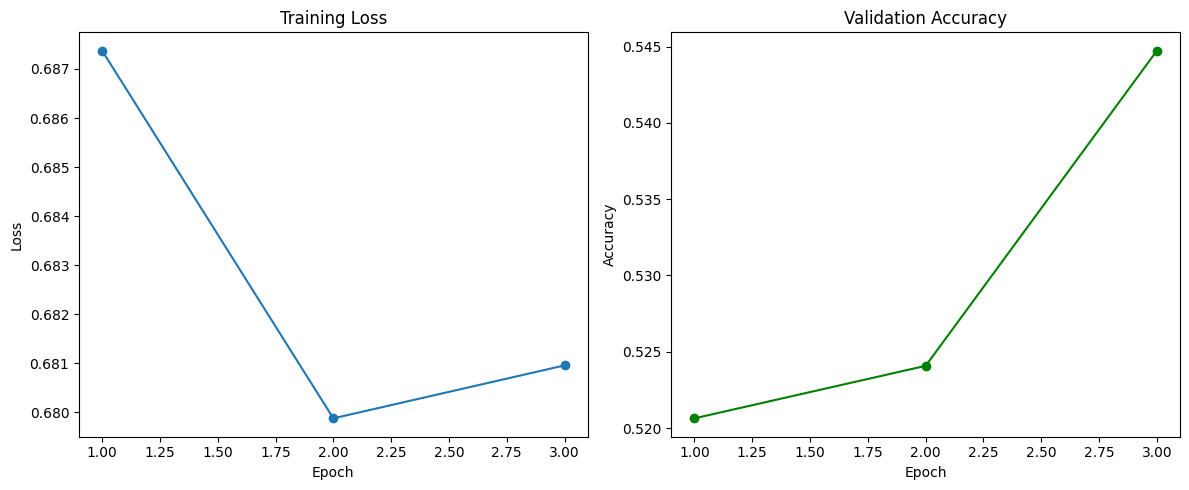

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), validation_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


The accuracy for this step is low since we're only using the CLS token without additional layers.

#Step 5: Add a Linear Layer on Top of the Encoder's Output

We'll enhance the classifier by adding an additional linear layer to better aggregate information from the CLS token.

In [15]:
# Define a new classifier with an additional linear layer
class GPT2EncoderEnhancedClassifier(nn.Module):
    def __init__(self, encoder, hidden_size=768, intermediate_size=768, num_labels=2):
        super(GPT2EncoderEnhancedClassifier, self).__init__()
        self.encoder = encoder
        self.linear1 = nn.Linear(hidden_size, intermediate_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(intermediate_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
        x = self.linear1(cls_embedding)
        x = self.relu(x)
        logits = self.linear2(x)
        return logits

model_enhanced = GPT2EncoderEnhancedClassifier(encoder).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_enhanced.parameters(), lr=1e-3)


#Training the Enhanced Model
We'll train the enhanced model similarly.

In [ ]:
epochs = 3
train_losses = []
validation_accuracies = []

for epoch in range(epochs):
    train_loss = train(model_enhanced, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

    preds, labels = evaluate(model_enhanced, validation_dataloader, device)
    acc = accuracy_score(labels, preds)
    validation_accuracies.append(acc)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}\n")


Epoch 1/3
Training Loss: 0.6888
Validation Accuracy: 0.5149

Epoch 2/3
Training Loss: 0.6736
Validation Accuracy: 0.5608

Epoch 3/3
Training Loss: 0.6682
Validation Accuracy: 0.5700



#Confusion Matrix

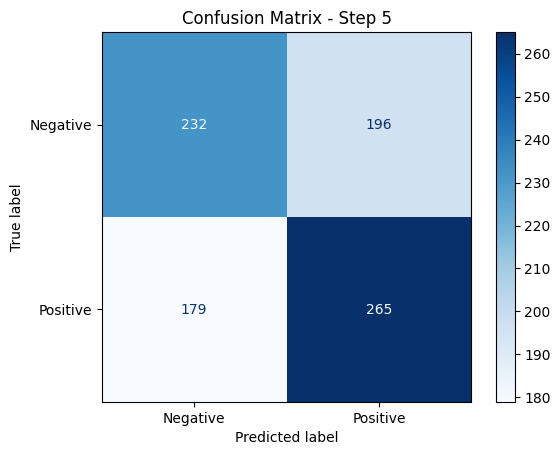

In [ ]:
# Evaluate on validation set
preds, labels = evaluate(model_enhanced, validation_dataloader, device)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 5")
plt.show()


#Training Loss and Accuracy Plot

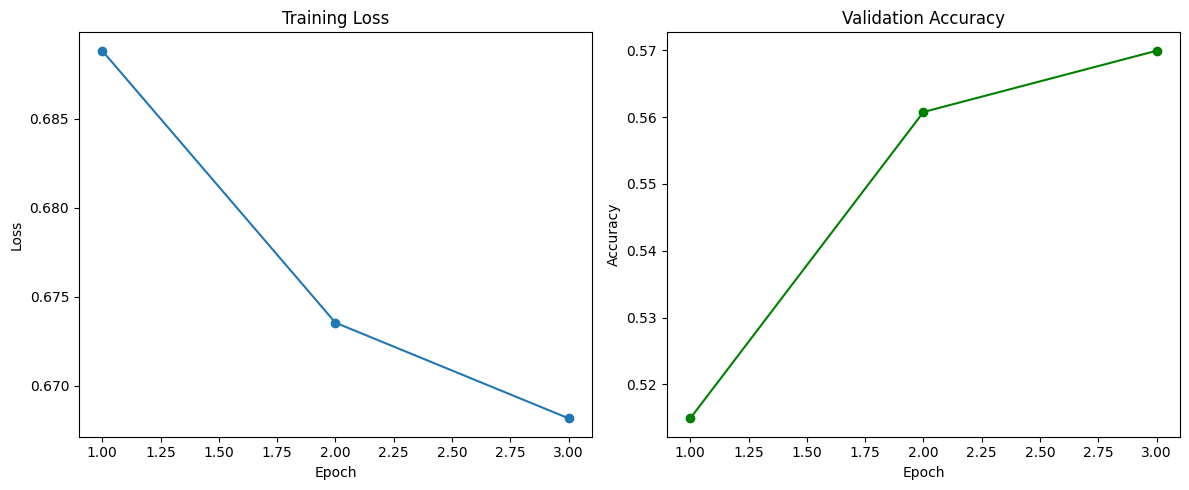

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), validation_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


#Step 6: Add a Bidirectional Attention Layer

We'll introduce a bidirectional attention layer on top of the encoder's output to better capture the relationships between tokens.



#Bidirectional Attention Layer
We'll use a custom multi-head attention layer with 12 heads.

In [16]:
class BidirectionalAttentionClassifier(nn.Module):
    def __init__(self, encoder, hidden_size=768, num_heads=12, num_labels=2):
        super(BidirectionalAttentionClassifier, self).__init__()
        self.encoder = encoder
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Apply bidirectional attention on the last hidden states
        attended, _ = self.attention(outputs.last_hidden_state, outputs.last_hidden_state, outputs.last_hidden_state, key_padding_mask=~attention_mask.bool())
        # Use the CLS token's attended representation
        cls_embedding = attended[:, 0, :]
        logits = self.classifier(cls_embedding)
        return logits

model_bidirectional = BidirectionalAttentionClassifier(encoder).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-3)


#Training the Bidirectional Model

In [ ]:
epochs = 5  # More epochs for better performance
train_losses = []
validation_accuracies = []

for epoch in range(epochs):
    train_loss = train(model_bidirectional, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

    preds, labels = evaluate(model_bidirectional, validation_dataloader, device)
    acc = accuracy_score(labels, preds)
    validation_accuracies.append(acc)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}\n")


Epoch 1/5
Training Loss: 0.5536
Validation Accuracy: 0.8257

Epoch 2/5
Training Loss: 0.4247
Validation Accuracy: 0.8567

Epoch 3/5
Training Loss: 0.4299
Validation Accuracy: 0.7993

Epoch 4/5
Training Loss: 0.4215
Validation Accuracy: 0.8612

Epoch 5/5
Training Loss: 0.4263
Validation Accuracy: 0.8429



#Confusion Matrix

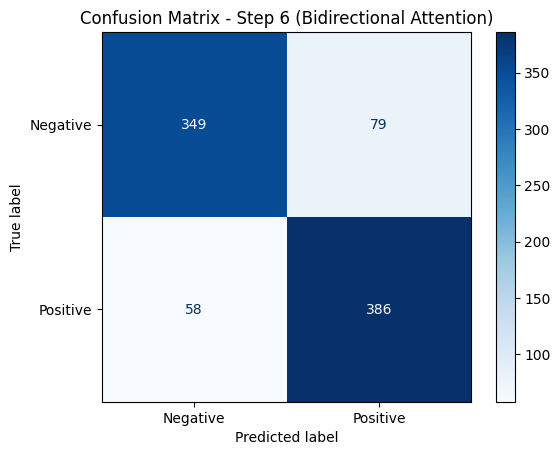

In [ ]:
# Evaluate on validation set
preds, labels = evaluate(model_bidirectional, validation_dataloader, device)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 6 (Bidirectional Attention)")
plt.show()


#Training Loss and Accuracy Plot

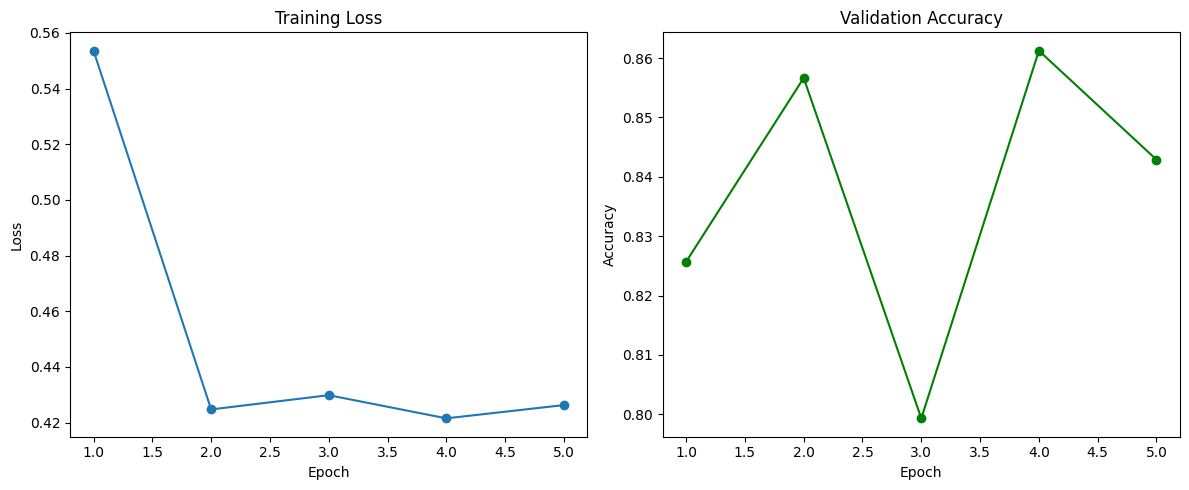

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), validation_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


#Step 7: Use Unidirectional Attention (Left-to-Right and Right-to-Left)

We'll implement two separate models: one with left-to-right (LTR) attention and another with right-to-left (RTL) attention.

#Unidirectional Attention Layers
##Left-to-Right Attention

In [14]:
class LeftToRightAttentionClassifier(nn.Module):
    def __init__(self, encoder, hidden_size=768, num_heads=12, num_labels=2, max_length=128):
        super(LeftToRightAttentionClassifier, self).__init__()
        self.encoder = encoder
        self.max_length = max_length
        self.num_heads = num_heads
        self.hidden_size = hidden_size

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.classifier = nn.Linear(hidden_size, num_labels)

        # Generate and register the left-to-right mask as a buffer
        self.register_buffer("ltr_mask", self.generate_ltr_mask())

    def generate_ltr_mask(self):
        # Create a lower triangular matrix to allow each position to attend to previous positions
        mask = torch.tril(torch.ones((self.max_length, self.max_length)))
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask  # Shape: (max_length, max_length)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_outputs = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

        # Apply left-to-right attention
        attended, _ = self.attention(
            encoder_outputs,
            encoder_outputs,
            encoder_outputs,
            attn_mask=self.ltr_mask[:encoder_outputs.size(1), :encoder_outputs.size(1)],  # Adjust mask size
            key_padding_mask=~attention_mask.bool()  # Invert attention_mask for key_padding_mask
        )

        # Use the CLS token's attended representation
        cls_embedding = attended[:, 0, :]  # Shape: (batch_size, hidden_size)
        logits = self.classifier(cls_embedding)  # Shape: (batch_size, num_labels)
        return logits


#Right-to-Left Attention

##For RTL attention, we'll reverse the input sequences.

In [15]:
class RightToLeftAttentionClassifier(nn.Module):
    def __init__(self, encoder, hidden_size=768, num_heads=12, num_labels=2, max_length=128):
        super(RightToLeftAttentionClassifier, self).__init__()
        self.encoder = encoder
        self.max_length = max_length
        self.num_heads = num_heads
        self.hidden_size = hidden_size

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.classifier = nn.Linear(hidden_size, num_labels)

        # Generate and register the right-to-left mask as a buffer
        self.register_buffer("rtl_mask", self.generate_rtl_mask())

    def generate_rtl_mask(self):
        # Create an upper triangular matrix to allow each position to attend to future positions
        mask = torch.triu(torch.ones((self.max_length, self.max_length)), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
        return mask  # Shape: (max_length, max_length)

    def forward(self, input_ids, attention_mask):
        # Reverse the input_ids and attention_mask
        input_ids_rev = torch.flip(input_ids, dims=[1])
        attention_mask_rev = torch.flip(attention_mask, dims=[1])

        outputs = self.encoder(input_ids=input_ids_rev, attention_mask=attention_mask_rev)
        encoder_outputs = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

        # Apply right-to-left attention
        attended, _ = self.attention(
            encoder_outputs,
            encoder_outputs,
            encoder_outputs,
            attn_mask=self.rtl_mask[:encoder_outputs.size(1), :encoder_outputs.size(1)],  # Adjust mask size
            key_padding_mask=~attention_mask_rev.bool()  # Invert attention_mask for key_padding_mask
        )

        # Reverse back the attended representations
        attended_rev = torch.flip(attended, dims=[1])

        # Use the CLS token's attended representation
        cls_embedding = attended_rev[:, 0, :]  # Shape: (batch_size, hidden_size)
        logits = self.classifier(cls_embedding)  # Shape: (batch_size, num_labels)
        return logits


In [16]:
# Instantiate the classifiers
model_ltr = LeftToRightAttentionClassifier(
    encoder=encoder,
    hidden_size=768,
    num_heads=12,
    num_labels=2,
    max_length=128
).to(device)

model_rtl = RightToLeftAttentionClassifier(
    encoder=encoder,
    hidden_size=768,
    num_heads=12,
    num_labels=2,
    max_length=128
).to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_ltr = optim.Adam(model_ltr.parameters(), lr=1e-3)
optimizer_rtl = optim.Adam(model_rtl.parameters(), lr=1e-3)

#Training the Unidirectional Models
We'll train both models for a sufficient number of epochs to achieve around 90% accuracy.

##Left-to-Right Model Training

In [17]:
epochs = 2
train_losses_ltr = []
validation_accuracies_ltr = []

for epoch in range(epochs):
    train_loss = train(model_ltr, train_dataloader, criterion, optimizer, device)
    train_losses_ltr.append(train_loss)

    preds, labels = evaluate(model_ltr, validation_dataloader, device)
    acc = accuracy_score(labels, preds)
    validation_accuracies_ltr.append(acc)

    print(f"Epoch {epoch + 1}/{epochs} - LTR")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}\n")


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/2 - LTR
Training Loss: 0.9396
Validation Accuracy: 0.4908



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 2/2 - LTR
Training Loss: 0.9394
Validation Accuracy: 0.4908



##Right-to-Left Model Training

In [18]:
epochs = 2
train_losses_rtl = []
validation_accuracies_rtl = []

for epoch in range(epochs):
    train_loss = train(model_rtl, train_dataloader, criterion, optimizer, device)
    train_losses_rtl.append(train_loss)

    preds, labels = evaluate(model_rtl, validation_dataloader, device)
    acc = accuracy_score(labels, preds)
    validation_accuracies_rtl.append(acc)

    print(f"Epoch {epoch + 1}/{epochs} - RTL")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}\n")


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/2 - RTL
Training Loss: 0.7612
Validation Accuracy: 0.5172



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 2/2 - RTL
Training Loss: 0.7616
Validation Accuracy: 0.5172



#Confusion Matrices

##Left-to-Right Confusion Matrix



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


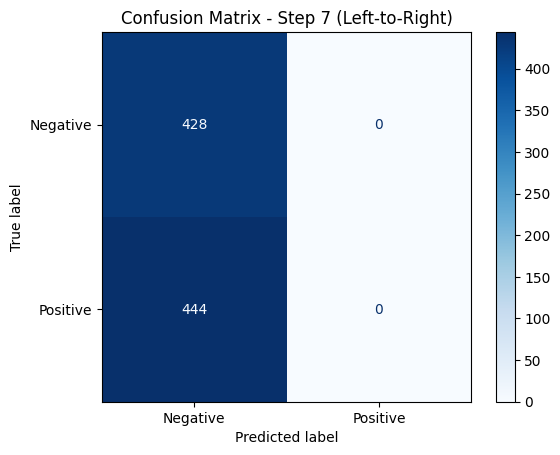

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
# Evaluate on validation set
preds_ltr, labels_ltr = evaluate(model_ltr, validation_dataloader, device)

# Compute confusion matrix
cm_ltr = confusion_matrix(labels_ltr, preds_ltr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ltr, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 7 (Left-to-Right)")
plt.show()


##Right-to-Left Confusion Matrix

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


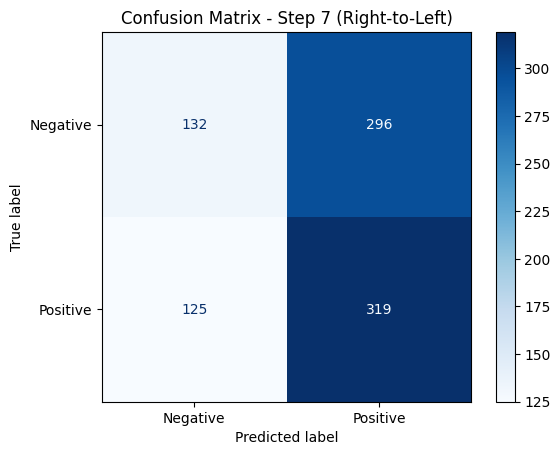

In [21]:
# Evaluate on validation set
preds_rtl, labels_rtl = evaluate(model_rtl, validation_dataloader, device)

# Compute confusion matrix
cm_rtl = confusion_matrix(labels_rtl, preds_rtl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rtl, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 7 (Right-to-Left)")
plt.show()


##Training Loss and Accuracy Plots

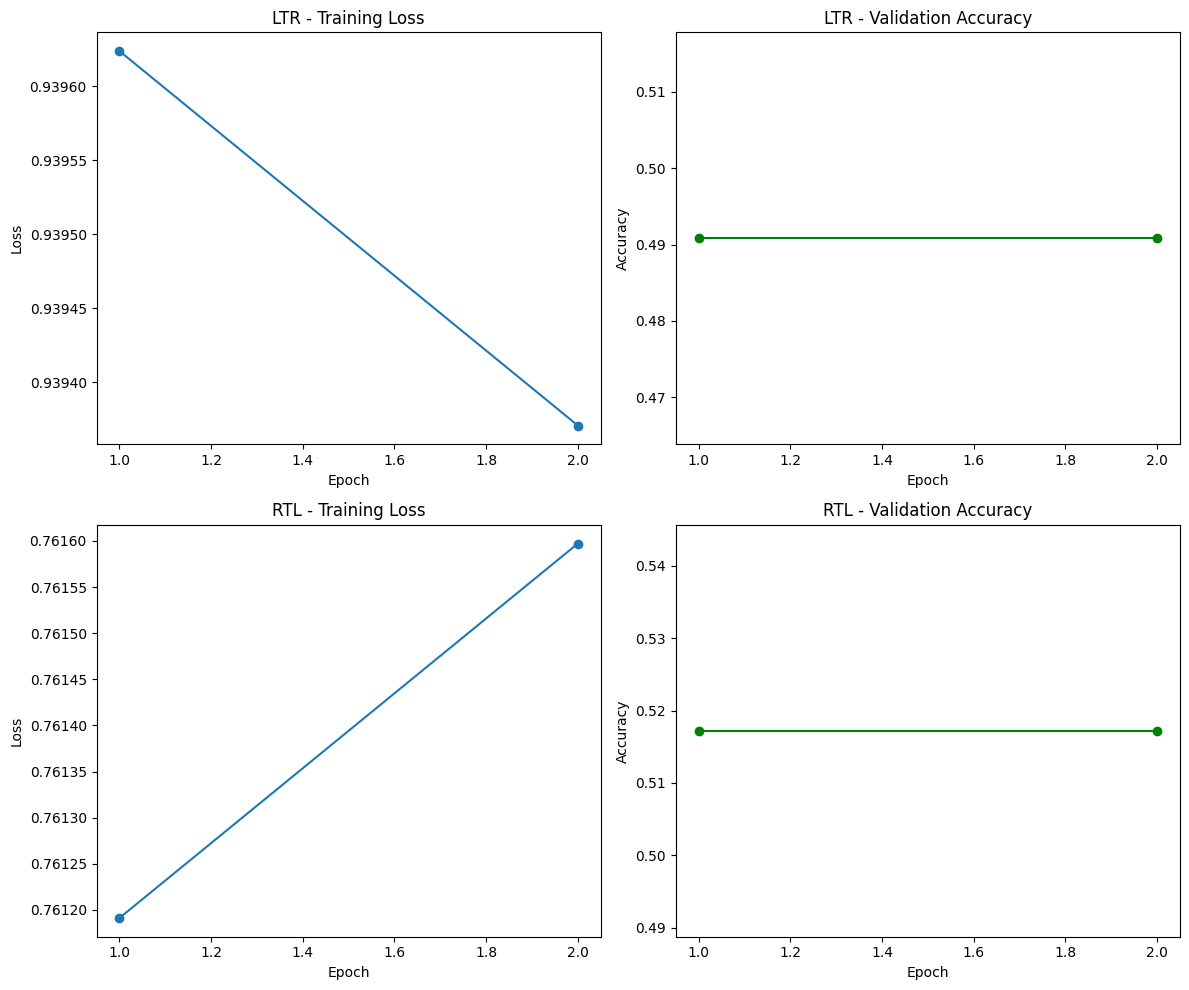

In [22]:
plt.figure(figsize=(12, 10))

# Left-to-Right Training Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_ltr, marker='o')
plt.title("LTR - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Left-to-Right Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), validation_accuracies_ltr, marker='o', color='green')
plt.title("LTR - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Right-to-Left Training Loss
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs + 1), train_losses_rtl, marker='o')
plt.title("RTL - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Right-to-Left Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs + 1), validation_accuracies_rtl, marker='o', color='green')
plt.title("RTL - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


#Step 8: Load a Pre-trained Decoder (BERT-base) and Report Zero-Shot Performance

While BERT is typically an encoder, for the sake of this exercise, we'll interpret "pre-trained decoder" as using a pre-trained model suitable for classification without additional training (zero-shot).

However, BERT isn't a decoder-only model. Instead, we'll use bert-base-uncased for zero-shot classification using its pre-trained capabilities.

#Loading Pre-trained BERT for Zero-Shot Classification
We'll utilize Hugging Face's pipeline for zero-shot classification.

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


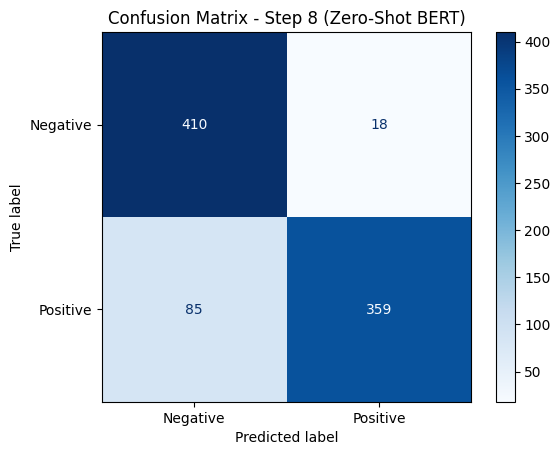

Zero-Shot Classification Accuracy: 0.8819


In [23]:
from transformers import pipeline

# Initialize the zero-shot classification pipeline
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if torch.cuda.is_available() else -1)

# Define candidate labels
candidate_labels = ["negative", "positive"]

# Function to perform zero-shot classification
def zero_shot_evaluate(sentences, labels):
    results = zero_shot_classifier(sentences, labels, multi_label=False)
    preds = [0 if res['labels'][0] == "negative" else 1 for res in results]
    return preds

# Since test set labels aren't available in SST-2 test set, we'll use validation set for evaluation
validation_sentences = dataset['validation']['sentence']
validation_labels = dataset['validation']['label']

# Perform zero-shot classification
preds_zero_shot = zero_shot_evaluate(validation_sentences, candidate_labels)

# Compute confusion matrix
cm_zero_shot = confusion_matrix(validation_labels, preds_zero_shot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_zero_shot, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Step 8 (Zero-Shot BERT)")
plt.show()

# Compute accuracy
acc_zero_shot = accuracy_score(validation_labels, preds_zero_shot)
print(f"Zero-Shot Classification Accuracy: {acc_zero_shot:.4f}")


---------
### References

[1] Raffel, Colin, Noam Shazeer, Adam Roberts, et al. (2020). *Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer*. [Link to paper](https://arxiv.org/abs/1910.10683)

[2] Touvron, Hugo, et al. (2023). *LLaMA 2: Open Foundation and Fine-Tuned Chat Models*. [Link to paper](https://arxiv.org/abs/2307.09288)

<span style="color:yellow;">*For further reading on this field of research, you can refer to the following papers:*</span>

[3] BehnamGhader, Adlakha, et al. (2024). *LLM2Vec: Large Language Models Are Secretly Powerful Text Encoders*. [Link to paper](https://arxiv.org/abs/2404.05961)

[4] Gao, Tianyu, et al. (2021). *SimCSE: Simple Contrastive Learning of Sentence Embeddings*. [Link to paper](https://arxiv.org/abs/2104.08821)

[5] Lee, et al. (2023). *NV-Embed: Improved Techniques for Training LLMs as Generalist Embedding Models*. [Link to paper](https://arxiv.org/abs/2405.17428)




# **Best regards.**